# Lecture 5
## A real Machine Learning Project
In this lecture, you will go through an example project from start to end, as if you were a fresh
hired data scientist.

Here is an overview of all the steps you are going through.

1. Frame the problem and look at the big picture
2. Get the data
3. Discover and visualize the data to gain insights
4. Prepare the data for Machine Learning Algorithms
5. Select a model and train it
6. Fine-tune your model.
7. Present your solution.
8. Launch, monitor, and maintain your system.


## Look at the Big Picture and Frame the Problem
In this Lecture you are going to work with a classic dataset, which is the California Housing Prices,
which contains information about houses based on data from the 1990 California census.

The data refers to the houses found in a given California district and some summary stats about them based on the 1990 census data. 
Be warned the data aren't cleaned so there are some preprocessing steps required! The columns are as follows, their names are pretty self explanitory:

* longitude
* latitude
* housing_median_age
* total_rooms
* total_bedrooms
* population
* households
* median_income
* median_house_value
* ocean_proximity


First, you have to think about what you are asked to. In this context you are required to buld a model of
housing prices in California. 

More specifically, you are asked to predict the price associated with a *block*, 
namely a small geographical unit (per intenderci: un quartiere, un distretto, un rione, una contrada...and so on).

Your model should learn from this data and finally be able to predict the median housing price in any district.

Now that you understood the main goal of this project, you should go into the details of the problem you are asked to
solve.

Moreover you have to focus on the entire pipeline of the project. In fact your model may be part of
more complex and longer pipeline of intelligent systems. 

For instance, the model you are going to build may be part of the following pipeline.

![](img/pipeline.png)


---

**Question**

Think about what kind of problem you are asked to solve? is it a classification problem? is it a regression problem or clustering problem?

*Answer*: ....


----

Once you decided how to tackle the problem, you need to find a suitable way of measuring performance. 

There are some common options.

> **Root Means Squared Error**
    It measures standard deviation of the errors the system makes. 
    It is given by:
    $$
        RMSE(X,h) = \sqrt{\frac{1}{m} \sum_{i=1}^{m} (h(x^{(i)}) - y^{(i)})^2}
    $$
    
> **Mean Absolute Error**
    It measures teh performance as:
    $$
        MAE(X,h) = \frac{1}{m} \sum_{i=1}^{m} | h(x^{(i)}) - y^{(i)}|
    $$
    
Both of them are a way of measuring distance between vectors. In particular, the RMSE corresponds to the *Euclidian distance* ($l_2$ norm)
while the MAE corrensponds to the *Manhattan norm* ($l_1$ distance).

In generale the higher the norm the more sensitive the algorithm will be to outlier. In fact, RMSE is more sensitive
to outlier than MAE. In fact, as $k$ increases the algorithm will focus more on large values rather than smaller ones.

This is one of the reason we use features scaling, in particular standardization algong with RMSE, in fact a bell-shaped curve
will enhance the RMSE performance.



# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "img")

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Get the data

In [2]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def maybe_fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    # check wether the dataset is already
    # in the filesytesm
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)

    # make the request to download the compressed file    
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    
    # open and decompress the file
    housing_tgz = tarfile.open(tgz_path) 
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
maybe_fetch_housing_data()

In [4]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
housing = load_housing_data()

## Take a Quick Look at the Data Structure
Just issue the usual instructions for a quick preview of the data.

In [6]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Look at this result. It appears that ``total_bedrooms`` contains some missing values 
(you will address the problem later). 

All attributes are numerical, except the ``ocean_proximity`` field, as the 
type ``object`` suggests. 

In fact, this feature contains text.

In [40]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

As usual, the ``describe`` function provides useful information about the data distribution.

In [41]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


A more intuitive way of taking a look at the data is by drawing some graphs.

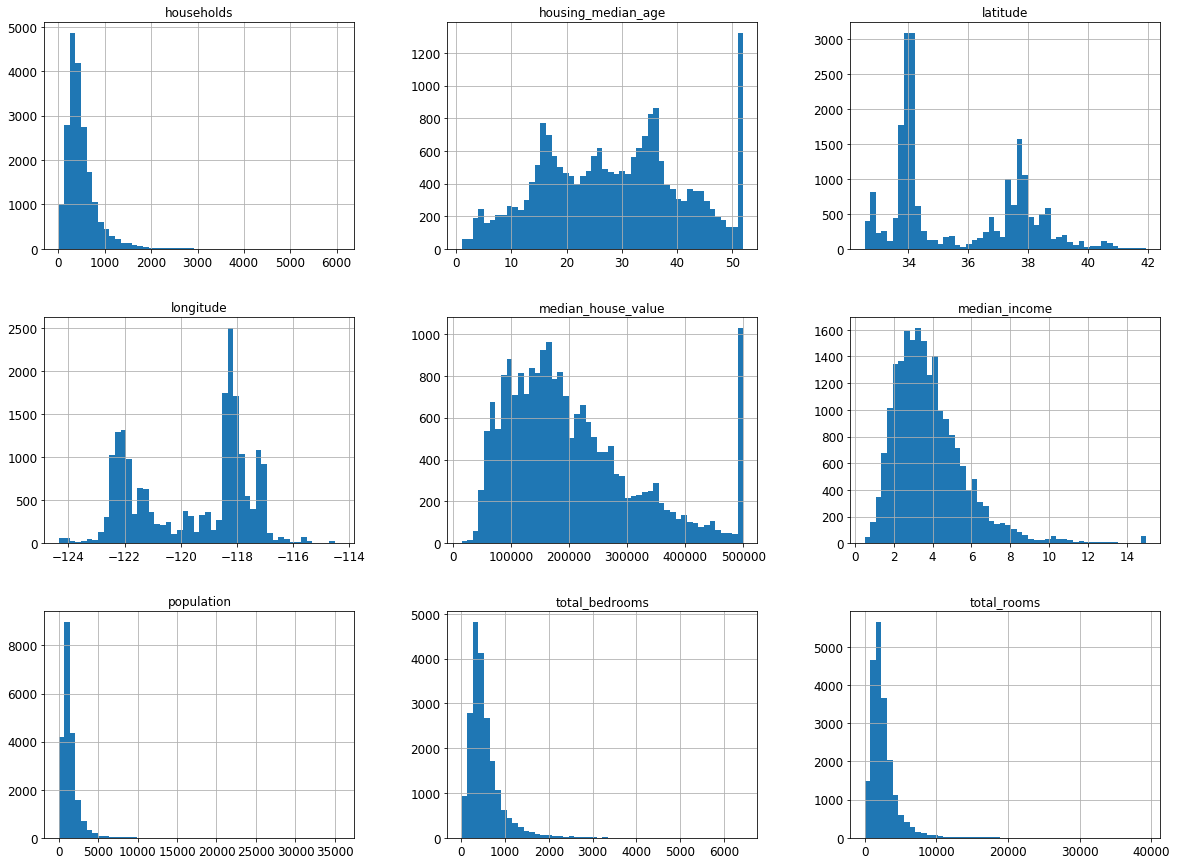

In [42]:
# plot some graphs useful for visualizing the distribution of
# the values wrt to each individual feature
%matplotlib inline
import matplotlib.pyplot as plt

#your code here

housing.hist(bins=50, figsize=(20,15))
#save_fig("attribute_histogram_plots")
plt.show()

Notice a few things in these histograms:

1. ``median_income`` - draw your consideration - they are within 0, 15 like if they were scaled and then capped at 15.
2. ``median_house_age`` and ``median_house_value``  - draw your consideration - it appears that also this values have been capped like if houeses with price >5000 and age >50 have been treated the same way.
3. Look at the scales - draw your considerations 
4. Look at the shape of the distribution. Remember, in order to work well RMSE need a bell-shaped curve. - draw your considerations

## Create a  Test Set
It might seems strange to put aside part of the data already at this early stage.

There is a reason for doing it, you must always avoid the *data snooping bias*. It is tempted to look at your data in order to make some 
useful observation, but you must always have a portion of the data your algorithm has never seen before.

In [43]:
import numpy as np
# your code here
# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [44]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


Instead of writing the function yourself, maybe ``sklearn`` would come in handy.

In fact it provides a useful function for splitting your data into train and test set.

In [45]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

There are several reasons why you should prefer this function.

Firt of all, you must be aware that, unless your dataset is large enough, you may incour the risk of introducing sampling
bias.

But, the most important aspect to consider when splitting the data is ensuring that the 
test set is well-constructed, it must be representative of the original data.

**Example**
When a survey
company decides to call 1,000 people to ask them a few questions, they don’t just pick
1,000 people randomly in a phone booth. 
They try to ensure that these 1,000 people are representative of the whole population. 

For example, the US population is com posed of 51.3% female and 48.7% male, so a well-conducted survey in the US would
try to maintain this ratio in the sample: 513 female and 487 male. 

This is called *stratified sampling*: the population is divided into homogeneous subgroups called *strata*,
and the right number of instances is sampled from each stratum to guarantee that the
test set is representative of the overall population. 

If they used purely random sampling, there would be about 12% chance of sampling a skewed test set with either less
than 49% female or more than 54% female. Either way, the survey results would be
significantly biased

---


You have to ensure that the test set is representative of the various categories of incomes in the whole dataset.

To be sure that the test set is representive you should compare the distribution inside the training set
with the distribution of the test set.

In [8]:
test_set.head()

NameError: name 'test_set' is not defined

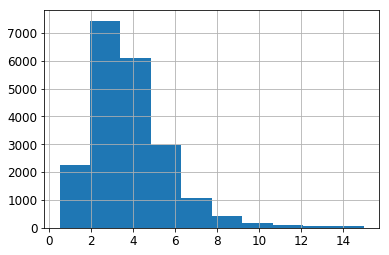

In [47]:
housing["median_income"].hist()

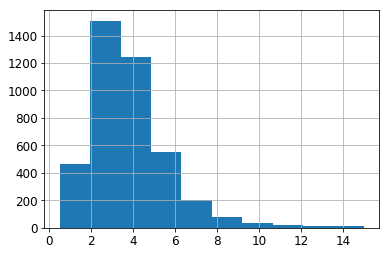

In [48]:
test_set["median_income"].hist()

As you can see the two distributions are quite similar, therefore you can conclude that there is no
sampling bias.

---
Now let's focus on a slightly different scenario. 

Suppose you already know that ``median_income`` is an important feature.

In this case you want to be sure that each value for ``median_income`` is
sufficiently represented inside the test set, i.e., you want to ensure
that for each ''category'' of ``median_income``has enough sample in the the test set.

As you can see from the histogram, most of the values are concentrated whithin 2 and 5.

Therefore you want to guarantee that this peculiarity persists in the 
test set.

In [49]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [50]:
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

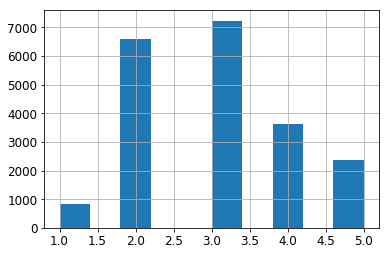

In [51]:
housing["income_cat"].hist()

Now you are ready to do stratified sampling based on the income category. 
For this you can use Scikit-Learn’s ``StratifiedShuffleSplit`` class.

In this case each value different value for ``income_cat`` is considered as
a strata.

In [52]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

Let's see it it worked as expected

In [53]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [54]:
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

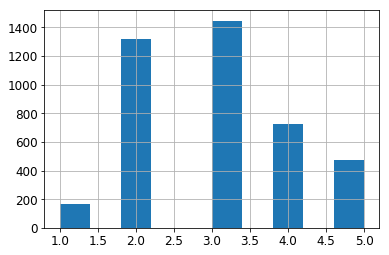

In [55]:
strat_test_set['income_cat'].hist()

In [56]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [57]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


Now you may remove the ``income_cat`` feature in order to get back to the original dataset.

In [58]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Discover and visualize the data to gain insights
So far you have only give a quick glance at the data. However there is no better way that plot your data in order to get some insights.

Let’s create a copy so you can play with it without
harming the training set


In [59]:
housing = strat_train_set.copy()

Saving figure bad_visualization_plot


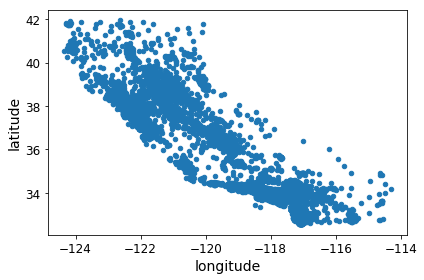

In [60]:
# scatter plot of longitude and latitude
housing.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization_plot")

It is pretty awful right?
One way to make it more pleasily it to set a different ``alpha``.


Saving figure better_visualization_plot


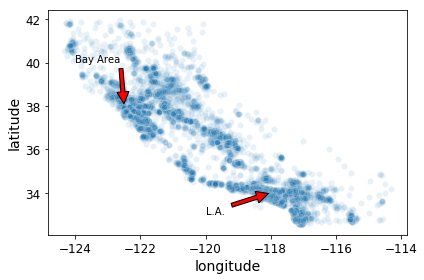

In [61]:
import seaborn as sns
ax = sns.scatterplot(data=housing, x="longitude", y="latitude", alpha=0.1)
ax.annotate('Bay Area', xy=(-122.5, 38), xytext=(-124,40 ), xycoords='data',
            arrowprops=dict(facecolor='red', shrink=0.05),
            )
ax.annotate('L.A. ', xy=(-118, 34), xytext=(-120,33), xycoords='data',
            arrowprops=dict(facecolor='red', shrink=0.05),
            )
save_fig("better_visualization_plot")

As the scatter plot suggests most of the data come from the Bay Area and the region around L.A. and San Diego.

Now let’s include the housing prices. 
The radius of each circle represents
the district’s population (option ``s``), and the color represents the price (option ``c``). We
will use a predefined color map (option ``cmap`` ) called ``"jet"`` , which ranges from blue
(low values) to red (high prices):

Saving figure housing_prices_scatterplot


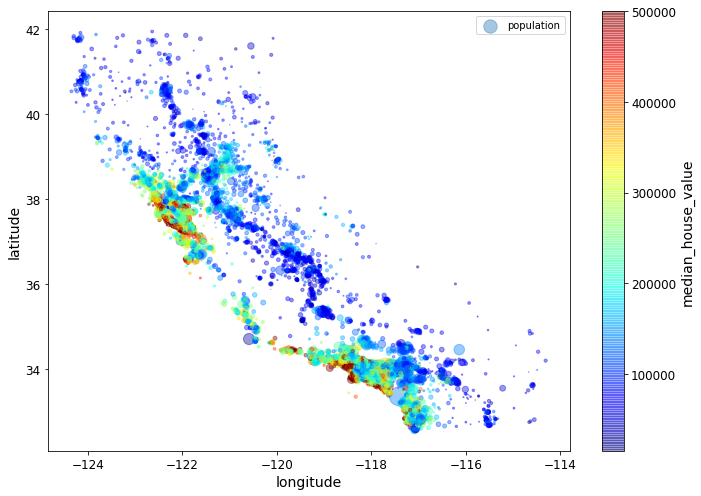

In [62]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

A more fancy, yet beatufiul way of displaying this information would be...

Saving figure california_housing_prices_plot


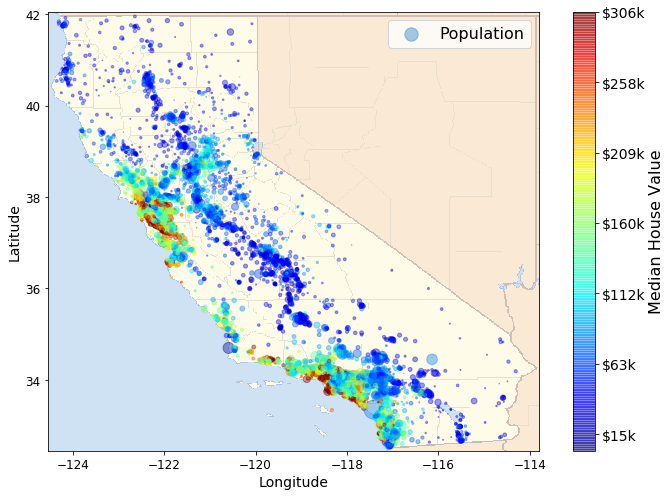

In [63]:
import matplotlib.image as mpimg
california_img=mpimg.imread(PROJECT_ROOT_DIR + '/img/california.png')
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

## Looking for Correlations
If the dataset is not too large you can compute the *standard correlation coefficient* (also known as the Pearson's coefficient).

This coefficient quantify how much two features are correlated with each other.


In [64]:
corr_matrix = housing.corr()

Since you are interesetd in predicting the ``median_house_value`` we can look at how much the other
features are correlated with it.

In [65]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

The coefficients range from -1 to 1. A value of -1 means there is a strong negative correlation, while a value of +1 means there is
a strong positive correlation.

As the coefficient approach to $0$ it means there is no correlation between the features.

***
You must be careful when using the linear correlation coefficient. In fact it is able to capture a linear 
relationships between features, while it completely fails to caputer any non-linear correlation.
***

Now that you know which are the most reasonable features to take into account, why don't you plot it?

Saving figure scatter_matrix_plot


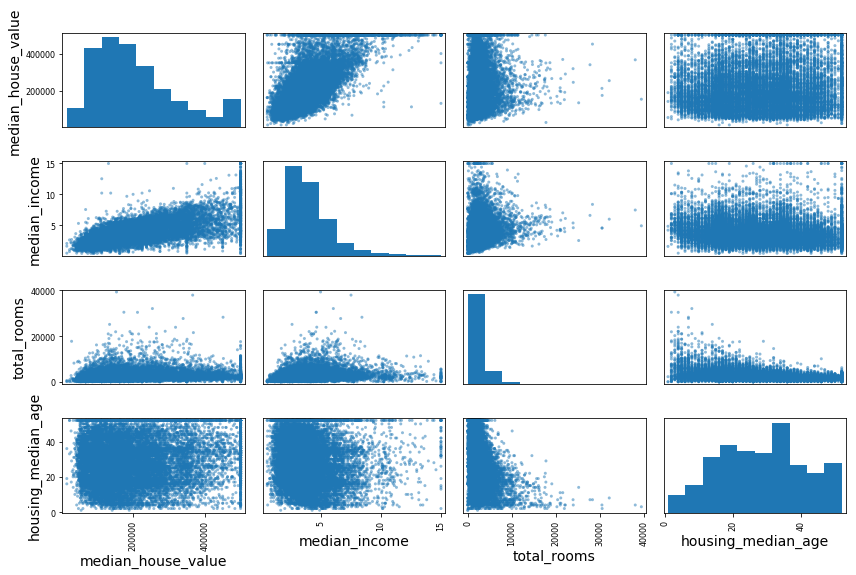

In [66]:
# from pandas.tools.plotting import scatter_matrix
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

Take a look at the results.  Which is the most promising feature?

Saving figure income_vs_house_value_scatterplot


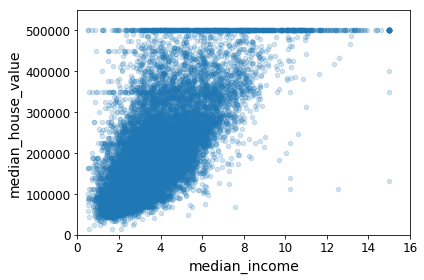

In [67]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.2)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

There are some strange patterns in this figure.

I fact there are some straight lines, why?

## Experimenting with Attribute Combinations

One last thing you may want to do before actually preparing the data for Machine
Learning algorithms is to try out various attribute combinations.

For instance, the total number of rooms inside a district is not very useful 
if you don’t know how many households there are. 

What would be really useful is the rooms per household.



In [68]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]

Think about some other attributes that may be transformed as the ``total_rooms`` feature.

In [69]:
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

Now, in order to check if these transformations were really useful you may want to compute the
correlation matrix once again.

In [70]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

Not bad! The new ``bedrooms_per_room`` attribute is much more correlated with
the median house value than the total number of rooms or bedrooms.

### Review
One important lesson to understand at this stage is that gaining isight from the data will help to build
a reasonably good prototype model. However, you must remember that this is an iterative process, you can always 
explore a path before deciding it is time tow try something else.

# Prepare the data for Machine Learning algorithms

First, you need to separate the Xs from the ys.

In [71]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

## Data Cleaning
Remember from the previous section, the ``total_bedroom`` feature has some missing values. 
You already know which are the possible ways for addressing this problem. 

This time, we decide to replace the missing values with teh median value wrt to the 
considered attribute.

In [72]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


In [73]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN


Instead of using pandas you can use the ``Imputer`` class of sklearn.

First, you need to create an Imputer instance, specifying that you want
to replace each attribute’s missing values with the median of that attribute:

In [74]:
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer

imputer = SimpleImputer(strategy="median")

Remove the text attribute because median can only be calculated on numerical attributes:

In [75]:
housing_num = housing.drop('ocean_proximity', axis=1)
# alternatively: housing_num = housing.select_dtypes(include=[np.number])

Now you can fit the imputer instance to the training data using the ``fit()`` method:

In [76]:
imputer.fit(housing_num)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

In [77]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

The imputer has simply computed the median of each attribute and stored the result
in its statistics_ instance variable. 

Only the total_bedrooms attribute had missing values, but we cannot be sure that there won’t be any missing values in new data after
the system goes live, so it is safer to apply the imputer to all the numerical attributes.

Check that this is the same as manually computing the median of each attribute.

In [78]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Now you can use this “trained” imputer to transform the training set by replacing
missing values by the learned medians:

In [79]:
X = imputer.transform(housing_num)

The result is a plain Numpy array containing the transformed features. If you want to
put it back into a Pandas DataFrame, it’s simple.

In [80]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index = list(housing.index.values))

In [81]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662


---
**Aside: Scikit-Learn Design**

Here are some of the main design princoples of the Scikit-Learn's API


* **Consistency**. All objects share a consistent and simple interface
    * *Estimators* - Any object that can estimate some parameters based on a dataset
       is called an estimator (e.g., an imputer is an estimator). The estimation itself is
       performed by the fit() method, and it takes only a dataset as a parameter (or
       two for supervised learning algorithms; the second dataset contains the
       labels). Any other parameter needed to guide the estimation process is con
       sidered a hyperparameter (such as an imputer ’s strategy ), and it must be set
       as an instance variable (generally via a constructor parameter).
    * *Transformers* - Some estimators (e.g., the imputer) can also transfom a dataset. 
       The transformation is performed by the ``transform()`` method with the dataset to
       transform as a parameter. It returns the transformed dataset.
       
       All the transformer also have a convenient method called ``fit_transform()`` which performs
       both the fit and the transform stages in a single step.
    * *Predictors* - some estimators are capable of making predictions given a dataset (e.g., ``LinearRegression``).
        A predictor has a ``predict()`` method that takes a
        dataset of new instances and returns a dataset of corresponding predictions. It
        also has a ``score()`` method that measures the quality of the predictions given
        a test set
        
* **Inspection** - All the estimator’s hyperparameters are accessible directly via public
    instance variables (e.g., ``imputer.strategy`` ), and all the estimator’s learned
    parameters are also accessible via public instance variables with an underscore
    suffix (e.g., ``imputer.statistics_``)     
    
* **Nonproliferation** of classes. Datasets are represented as NumPy arrays or SciPy
sparse matrices, instead of homemade classes. Hyperparameters are just regular
Python strings or numbers.

* **Composition**. Existing building blocks are reused as much as possible. For
example, it is easy to create a Pipeline estimator from an arbitrary sequence of
transformers followed by a final estimator, as we will see.

* **Sensible defaults**. Scikit-Learn provides reasonable default values for most
parameters, making it easy to create a baseline working system quickly.

---

### Handling Text and Categorical Attributes
Now let's preprocess the categorical input feature, `ocean_proximity`:

In [82]:
housing_cat = housing.select_dtypes(include=['object'])
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


sklearn provides a class for transforming categorical values into numerical values.

In [83]:
try:
    from sklearn.preprocessing import OrdinalEncoder
except ImportError:
    from future_encoders import OrdinalEncoder # Scikit-Learn < 0.20

In [84]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [85]:
print(ordinal_encoder.categories_)

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


However, dealing with categorical data in this way is not the best choiche.

In fact one issue that may occur is that ML algorithm will assume that two nearby values have a similar meaning.

This is not always the case, especially in our context. 

In fact the fact  "<1H OCEAN" and "INLAND" are not similar at all, despite their close corresponding numerical values.

For this reason it is always better to transofrm categorical value according to a one-hot-encoding strategy.

Obviously, sklearn provides a transformer: the ``OneHotEncoder``.

In [86]:
try:
    from sklearn.preprocessing import OrdinalEncoder # just to raise an ImportError if Scikit-Learn < 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder # Scikit-Learn < 0.20

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

By default, the `OneHotEncoder` class returns a sparse array, but we can convert it to a dense array if needed by calling the `toarray()` method:

In [87]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

Alternatively, you can set `sparse=False` when creating the `OneHotEncoder`:

In [88]:
print(cat_encoder.categories_)

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


Let's create a custom transformer to add extra attributes:

In [89]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

## Custom Transformers

Although Scikit-Learn provides many useful transformers, you will need to write
your own for tasks such as custom cleanup operations or combining specific
attributes. 

You will want your transformer to work seamlessly with Scikit-Learn func
tionalities (such as pipelines), and since Scikit-Learn relies on duck typing (not inher
itance), all you need is to create a class and implement three methods: ``fit()``
(returning ``self`` ), ``transform()`` , and ``fit_transform()``.

You can get the last one for
free by simply adding TransformerMixin as a base class. Also, if you add BaseEstima
tor as a base class (and avoid ``*args`` and ``**kargs`` in your constructor) you will get
two extra methods ( ``get_params()`` and ``set_params()``) that will be useful for auto
matic hyperparameter tuning. For example, here is a small transformer class that adds
the combined attributes we discussed earlier:

In [90]:
from sklearn.base import BaseEstimator, TransformerMixin

# get the right column indices: safer than hard-coding indices 3, 4, 5, 6
rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

Alternatively, you can use Scikit-Learn's `FunctionTransformer` class that lets you easily create a transformer based on a transformation function. 

Note that we need to set `validate=False` because the data contains non-float values (`validate` will default to `False` in Scikit-Learn 0.22).

In [91]:
from sklearn.preprocessing import FunctionTransformer # it works as a wrapper

def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]

attr_adder = FunctionTransformer(add_extra_features, validate=False,
                                 kw_args={"add_bedrooms_per_room": False})
housing_extra_attribs = attr_adder.fit_transform(housing.values)

In [92]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


## Feature Scaling
There are two common ways to get all attributes to have the same scale: *min-max
scaling* and *standardization*.

Machine Learning algorithms don’t perform well when
the input numerical attributes have very different scales.
This is the case for the housing data: the total number of rooms ranges from about 6 to 39,320, while the median
incomes only range from 0 to 15. Note that scaling the target values is generally not
required.

Scikit-Learn provides two transformers: (i)``MinMaxScaler``, (ii) ``StandardScaler``.

Like other transformers they provide the already seen ``fit()``-> ``transform()`` mechanism.



## Transformation Pipelines
Scikit-Learn provides the Pipeline class to help with
such sequences of transformations. Here is a small pipeline for the numerical
attributes:

In [93]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [94]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

The Pipeline constructor takes a list of name/estimator pairs defining a sequence of
steps. All but the last estimator must be transformers (the final object can also be a predictor).

When you call the pipeline’s fit() method, it calls fit_transform() sequentially on
all transformers, passing the output of each call as the parameter to the next call, until
it reaches the final estimator, for which it just calls the fit() method.

Now you have a pipeline for nomerical value, but you also need to apply some transformation upon
the categorical data. 
There is no problem, you can design and run two different pipelines, for instance the first works over
numerical values while the other takes as input all the categorical features, and then sklearn
provide the ``ColumnTransformer``.

*How does it work?*
This estimator allows different columns or column subsets of the input to be transformed separately and the features generated by each transformer will be concatenated to form a single feature space. This is useful for heterogeneous or columnar data, to combine several feature extraction mechanisms or transformations into a single transformer.

It asks for a list of tuples. Each tuple in the list contains: the name of the transformer, the transformer, the column upon which the transformations
need to be performed.

In [95]:
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20

In [96]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [97]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

# Select and train a model 

In [98]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Done! You now have a working Linear Regression model.

It is not so hard, isn't it? 

Now, let's use the trained regressor to make some prediction.

In [102]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
# the data need to be transformed according to the same pipeline used for the training set
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


Compare against the actual values:

In [84]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [85]:
some_data_prepared

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458,
        -0.43363936, -0.0933178 , -0.5320456 , -0.46531516, -0.09240499,
         0.4222004 ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.01706767,  0.31357576, -0.29052016, -0.36276217, -0.39675594,
         0.03604096, -0.38343559, -1.04556555, -0.07966124,  0.08973561,
        -0.19645314,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.49247384, -0.65929936, -0

It works. However we still need to understand the true value of our model.

A classic approach when working with regression problem is to use the RMSE error in order to measure
the performace.

In [103]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

Well, it is not a great score considering that the ``median_housing_values`` ranges between 120k and 265k.

Now, compute some other metric over the training set ($l_1$ loss function).

In [104]:
#your code here
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49439.89599001897

Usually, when a model does not perform well, the first thing you could do is trying with another
model! 

(Obviously, you first need to check if your results are correct, i.e., you are not messed up with something in your model or data preparation sack)

Why don't you try with ``DecisionTreeRegressor``?

In [105]:
# your code here
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [115]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Wow! 0 error! 

Should you be worried about this result or should you be happy for it?  Are you the legit ML GOAT?

## Better Evaluation Using Cross-Validation

One way to evaluate the Decision Tree model would be to use the train_test_split
function to split the training set into a smaller training set and a validation set, then
train your models against the smaller training set and evaluate them against the vali
dation set. It’s a bit of work, but nothing too difficult and it would work fairly wel

A great alternative is to use Scikit-Learn’s cross-validation feature. The following code
performs K-fold cross-validation: it randomly splits the training set into 10 distinct
subsets called folds, then it trains and evaluates the Decision Tree model 10 times,
picking a different fold for evaluation every time and training on the other 9 folds.
The result is an array containing the 10 evaluation scores:

In [116]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

print("Scores:", rmse_scores)
print("Mean: ", rmse_scores.mean())
print("Std.: ", rmse_scores.std())

Scores: [70194.33680785 66855.16363941 72432.58244769 70758.73896782
 71115.88230639 75585.14172901 70262.86139133 70273.6325285
 75366.87952553 71231.65726027]
Mean:  71407.68766037929
Std.:  2439.4345041191004


Scikit-Learn cross-validation features expect a utility function
(greater is better) rather than a cost function (lower is better), this is why you need
to stick the negative sign.

Now the Decision Tree doesn’t look as good as it did earlier.

In fact, it seems to per form worse than the Linear Regression model! 

Notice that cross-validation allows you to get not only an estimate of the performance of your model,
but also a measure gives you the average error (the standard deviation).

Now let's do the same thing with the linear regression estimator.

In [120]:
# your code
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345084
Standard deviation: 2731.6740017983466


#### Draw some conclusions...


Let's try something new. Here your are going to build a ``RandomForestRegressor`` (it is the ``ensamble`` module of sklearn).

It is an Ensamble Learning Method. Use it and see wether it can provide better performance.

**Note**: you need to specify `n_estimators=10` to avoid a warning about the fact that the default value is going to change to 100 in Scikit-Learn 0.22.

In [121]:
#your code here

# create and train the model
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [94]:
# compute some predictions
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

21933.31414779769

In [95]:
# compute the score of the model
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51646.44545909 48940.60114882 53050.86323649 54408.98730149
 50922.14870785 56482.50703987 51864.52025526 49760.85037653
 55434.21627933 53326.10093303]
Mean: 52583.72407377466
Standard deviation: 2298.353351147122


**Question**

Is there any sign of overfitting?

*Motivate your answer*...



## Fine-Tune Your Model

Let’s assume that you now have a shortlist of promising models. You now need to
fine-tune them.

### Grid Search

You should delegate to Scikit-Learn’s ``GridSearchCV`` to search for you.

For example, the following code searches for the best combi
nation of hyperparameter values for the RandomForestRegressor.

It should be noted that each dict is in ``param_grid`` is considered one at a time.
Sklearn also considers every possible combination of the selected parameters for the given model, therefore
it may take a while to finish.

In [122]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

When it is done, you can get the best hyperparameter combination found:

In [99]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

You can also take a reference directly to the best estimator.

In [100]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

Let's look at the score of each hyperparameter combination tested during the grid search:

In [101]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63669.05791727153 {'max_features': 2, 'n_estimators': 3}
55627.16171305252 {'max_features': 2, 'n_estimators': 10}
53384.57867637289 {'max_features': 2, 'n_estimators': 30}
60965.99185930139 {'max_features': 4, 'n_estimators': 3}
52740.98248528835 {'max_features': 4, 'n_estimators': 10}
50377.344409590376 {'max_features': 4, 'n_estimators': 30}
58663.84733372485 {'max_features': 6, 'n_estimators': 3}
52006.15355973719 {'max_features': 6, 'n_estimators': 10}
50146.465964159885 {'max_features': 6, 'n_estimators': 30}
57869.25504027614 {'max_features': 8, 'n_estimators': 3}
51711.09443660957 {'max_features': 8, 'n_estimators': 10}
49682.25345942335 {'max_features': 8, 'n_estimators': 30}
62895.088889905004 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54658.14484390074 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59470.399594730654 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52725.01091081235 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [102]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.060251,0.001252,0.004077,0.000397,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.837622e+09,-4.147108e+09,...,-4.053749e+09,1.519609e+08,18,-1.064113e+09,-1.105142e+09,-1.116550e+09,-1.112342e+09,-1.129650e+09,-1.105559e+09,2.220402e+07
1,0.195211,0.001845,0.010179,0.000394,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-3.047771e+09,-3.254861e+09,...,-3.094381e+09,1.327046e+08,11,-5.927175e+08,-5.870952e+08,-5.776964e+08,-5.716332e+08,-5.802501e+08,-5.818785e+08,7.345821e+06
2,0.589625,0.003846,0.030403,0.003266,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.689185e+09,-3.021086e+09,...,-2.849913e+09,1.626879e+08,9,-4.381089e+08,-4.391272e+08,-4.371702e+08,-4.376955e+08,-4.452654e+08,-4.394734e+08,2.966320e+06
3,0.098321,0.001313,0.003398,0.000078,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.730181e+09,-3.786886e+09,...,-3.716852e+09,1.631421e+08,16,-9.865163e+08,-1.012565e+09,-9.169425e+08,-1.037400e+09,-9.707739e+08,-9.848396e+08,4.084607e+07
4,0.322361,0.002503,0.010031,0.000395,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.666283e+09,-2.784511e+09,...,-2.781611e+09,1.268562e+08,8,-5.097115e+08,-5.162820e+08,-4.962893e+08,-5.436192e+08,-5.160297e+08,-5.163863e+08,1.542862e+07
5,0.964709,0.003208,0.026985,0.000617,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.387153e+09,-2.588448e+09,...,-2.537877e+09,1.214603e+08,3,-3.838835e+08,-3.880268e+08,-3.790867e+08,-4.040957e+08,-3.845520e+08,-3.879289e+08,8.571233e+06
6,0.132895,0.003371,0.003408,0.000064,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.119657e+09,-3.586319e+09,...,-3.441447e+09,1.893141e+08,14,-9.245343e+08,-8.886939e+08,-9.353135e+08,-9.009801e+08,-8.624664e+08,-9.023976e+08,2.591445e+07
7,0.443695,0.005027,0.010141,0.000682,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.549663e+09,-2.782039e+09,...,-2.704640e+09,1.471542e+08,6,-4.980344e+08,-5.045869e+08,-4.994664e+08,-4.990325e+08,-5.055542e+08,-5.013349e+08,3.100456e+06
8,1.343336,0.004695,0.027562,0.001805,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.370010e+09,-2.583638e+09,...,-2.514668e+09,1.285063e+08,2,-3.838538e+08,-3.804711e+08,-3.805218e+08,-3.856095e+08,-3.901917e+08,-3.841296e+08,3.617057e+06
9,0.169927,0.001055,0.003458,0.000110,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.353504e+09,-3.348552e+09,...,-3.348851e+09,1.241864e+08,13,-9.228123e+08,-8.553031e+08,-8.603321e+08,-8.881964e+08,-9.151287e+08,-8.883545e+08,2.750227e+07


## Randomized Search
Instead of providing directly all the possible combinations of parameters, you can use ``RandomizedSearchCV``.

It is especiallly useful when dealing with many hyperparameter or when the search space is too large.

It evaluates a given number of random combinations by selecting a random
value for each hyperparameter at every iteration. This approach has two main bene
fits:
1. 1.000 iterations will corresponds to 1000 different combinationtion for each hyperparameter
2. you have more control over the computing budget you want to allocate

In [103]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1210939e8>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x121093710>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [104]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49150.657232934034 {'max_features': 7, 'n_estimators': 180}
51389.85295710133 {'max_features': 5, 'n_estimators': 15}
50796.12045980556 {'max_features': 3, 'n_estimators': 72}
50835.09932039744 {'max_features': 5, 'n_estimators': 21}
49280.90117886215 {'max_features': 7, 'n_estimators': 122}
50774.86679035961 {'max_features': 3, 'n_estimators': 75}
50682.75001237282 {'max_features': 3, 'n_estimators': 88}
49608.94061293652 {'max_features': 5, 'n_estimators': 100}
50473.57642831875 {'max_features': 3, 'n_estimators': 150}
64429.763804893395 {'max_features': 5, 'n_estimators': 2}


## Analyze the Best Models and Their Errors
the RandomForestRegressor can indicate the relative importance of each
attribute for making accurate predictions.

In [124]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

Let’s display these importance scores next to their corresponding attribute names:

In [125]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3661589806181342, 'median_income'),
 (0.1647809935615905, 'INLAND'),
 (0.10879295677551573, 'pop_per_hhold'),
 (0.07334423551601242, 'longitude'),
 (0.0629090704826203, 'latitude'),
 (0.05641917918195401, 'rooms_per_hhold'),
 (0.05335107734767581, 'bedrooms_per_room'),
 (0.041143798478729635, 'housing_median_age'),
 (0.014874280890402767, 'population'),
 (0.014672685420543237, 'total_rooms'),
 (0.014257599323407807, 'households'),
 (0.014106483453584102, 'total_bedrooms'),
 (0.010311488326303787, '<1H OCEAN'),
 (0.002856474637320158, 'NEAR OCEAN'),
 (0.00196041559947807, 'NEAR BAY'),
 (6.028038672736599e-05, 'ISLAND')]

With this information, you may want to try dropping some of the less useful features
(e.g., apparently only one ocean_proximity category is really useful, so you could try
dropping the others).

---
### Evaluate Your System on the Test Set 
Now, you can select the best model on the training set and then evaluate its performance on the test set.

You can take the ``full_pipeline`` we constructed before, thus it is already trained, and call
the ``transform`` method in order to transform the data in the test set.

**Note:** Be careful! You need to transform the data according to the same parameters of the transformer object
obtained during the training stage. If you call fit upon the test set, it is an error!

In [107]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test) #!!!!!!!!! do not call fit or fit_transform!
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [108]:
final_rmse

47730.22690385927

**What to expect from this evaluation?**

The performance will usubally be slightly worse than what you measured using cross validation.

This is not the case, but it that happen you must avoid the trap of trying to fit the data
in the test set, usually the boost in performance will actually be a ''fake" improvement, since your model
will likely fail to generalize to new data.

# Extra material

## A full pipeline with both preparation and prediction

In [113]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([210644.60459286, 317768.80697211, 210956.43331178,  59218.98886849,
       189747.55849879])

## Model persistence using joblib

When you are done with the development of your model,
or if you want to save the progresses you have done so far,
it is better to save the model.

Scikit-Learn provides the module ``joblib`` for easily 
save and restore teh python object in a regular .pickle file.

You should always prefer ``joblib`` for storing your model
since it is generally more efficient than other serialization techniques.

In [114]:
my_model = full_pipeline_with_predictor

In [115]:
from sklearn.externals import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

# Exercises

## 1.

Question: Try a Support Vector Machine regressor (`sklearn.svm.SVR`), with various hyperparameters such as `kernel="linear"` (with various values for the `C` hyperparameter) or `kernel="rbf"` (with various values for the `C` and `gamma` hyperparameters). Don't worry about what these hyperparameters mean for now. How does the best `SVR` predictor perform?

In [117]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  9.4min
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 15.4min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid=[{'kernel': ['linear'], 'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0, 10000.0, 30000.0]}, {'kernel': ['rbf'], 'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0], 'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

The best model achieves the following score (evaluated using 5-fold cross validation):

In [118]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

70363.90313964167

That's much worse than the `RandomForestRegressor`. Let's check the best hyperparameters found:

In [119]:
grid_search.best_params_

{'C': 30000.0, 'kernel': 'linear'}

The linear kernel seems better than the RBF kernel. Notice that the value of `C` is the maximum tested value. When this happens you definitely want to launch the grid search again with higher values for `C` (removing the smallest values), because it is likely that higher values of `C` will be better.

## 2.

Question: Try replacing `GridSearchCV` with `RandomizedSearchCV`.

In [120]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# see https://docs.scipy.org/doc/scipy/reference/stats.html
# for `expon()` and `reciprocal()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, n_jobs=4, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 12.1min
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 19.6min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=50, n_jobs=4,
          param_distributions={'kernel': ['linear', 'rbf'], 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x13a243278>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x13a243e48>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=2)

The best model achieves the following score (evaluated using 5-fold cross validation):

In [121]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

54767.99053704408

Now this is much closer to the performance of the `RandomForestRegressor` (but not quite there yet). Let's check the best hyperparameters found:

In [122]:
rnd_search.best_params_

{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

This time the search found a good set of hyperparameters for the RBF kernel. Randomized search tends to find better hyperparameters than grid search in the same amount of time.

Let's look at the exponential distribution we used, with `scale=1.0`. Note that some samples are much larger or smaller than 1.0, but when you look at the log of the distribution, you can see that most values are actually concentrated roughly in the range of exp(-2) to exp(+2), which is about 0.1 to 7.4.

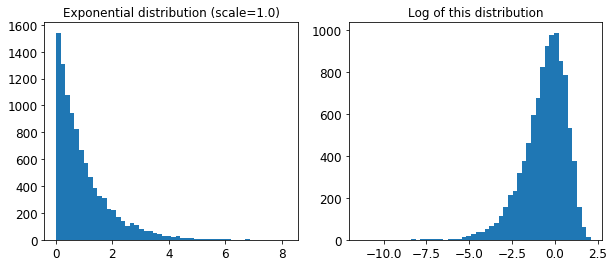

In [123]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

The distribution we used for `C` looks quite different: the scale of the samples is picked from a uniform distribution within a given range, which is why the right graph, which represents the log of the samples, looks roughly constant. This distribution is useful when you don't have a clue of what the target scale is:

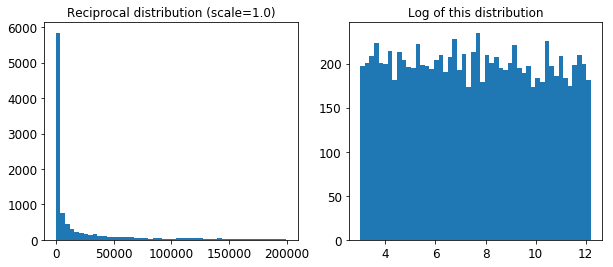

In [124]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

The reciprocal distribution is useful when you have no idea what the scale of the hyperparameter should be (indeed, as you can see on the figure on the right, all scales are equally likely, within the given range), whereas the exponential distribution is best when you know (more or less) what the scale of the hyperparameter should be.

## 3.

Question: Try adding a transformer in the preparation pipeline to select only the most important attributes.

In [125]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

Note: this feature selector assumes that you have already computed the feature importances somehow (for example using a `RandomForestRegressor`). You may be tempted to compute them directly in the `TopFeatureSelector`'s `fit()` method, however this would likely slow down grid/randomized search since the feature importances would have to be computed for every hyperparameter combination (unless you implement some sort of cache).

Let's define the number of top features we want to keep:

In [126]:
k = 5

Now let's look for the indices of the top k features:

In [127]:
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([ 0,  1,  7,  9, 12])

In [128]:
np.array(attributes)[top_k_feature_indices]

array(['longitude', 'latitude', 'median_income', 'pop_per_hhold',
       'INLAND'], dtype='<U18')

Let's double check that these are indeed the top k features:

In [129]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

[(0.3661589806181342, 'median_income'),
 (0.1647809935615905, 'INLAND'),
 (0.10879295677551573, 'pop_per_hhold'),
 (0.07334423551601242, 'longitude'),
 (0.0629090704826203, 'latitude')]

Looking good... Now let's create a new pipeline that runs the previously defined preparation pipeline, and adds top k feature selection:

In [130]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [131]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

Let's look at the features of the first 3 instances:

In [132]:
housing_prepared_top_k_features[0:3]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

Now let's double check that these are indeed the top k features:

In [133]:
housing_prepared[0:3, top_k_feature_indices]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

Works great!  :)

## 4.

Question: Try creating a single pipeline that does the full data preparation plus the final prediction.

In [134]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

In [135]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(memory=None,
     steps=[('preparation', ColumnTransformer(n_jobs=1, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0... gamma=0.26497040005002437, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))])

Let's try the full pipeline on a few instances:

In [136]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [203214.28978849 371846.88152572 173295.65441612  47328.3970888 ]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0]


Well, the full pipeline seems to work fine. Of course, the predictions are not fantastic: they would be better if we used the best `RandomForestRegressor` that we found earlier, rather than the best `SVR`.

## 5.

Question: Automatically explore some preparation options using `GridSearchCV`.

In [137]:
param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search_prep.fit(housing, housing_labels)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  9.7min
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed: 19.8min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preparation', ColumnTransformer(n_jobs=1, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0... gamma=0.26497040005002437, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid=[{'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'], 'feature_selection__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [138]:
grid_search_prep.best_params_

{'feature_selection__k': 15,
 'preparation__num__imputer__strategy': 'most_frequent'}

The best imputer strategy is `most_frequent` and apparently almost all features are useful (15 out of 16). The last one (`ISLAND`) seems to just add some noise.

Congratulations! You already know quite a lot about Machine Learning. :)